# CS 109B Advanced Topics in Data Science, Final Project, Milestone 4

## Group 9 - Steve Robbins, Chad Tsang, and Ted Heuer
**Harvard University**<br>
**Spring 2017**<br>
**Due Date: ** Wednesday, April 12th, 2017 at 11:59pm

### Milestone 4: Deep learning, due Wednesday, April 26, 2017

For this milestone you will (finally) use deep learning to predict movie genres. You will train one small network from scratch on the posters only, and compare this one to a pre-trained network that you fine tune. [Here](https://keras.io/getting-started/faq/#how-can-i-use-pre-trained-models-in-keras) is a description of how to use pretrained models in Keras.

You can try different architectures, initializations, parameter settings, optimization methods, etc. Be adventurous and explore deep learning! It can be fun to combine the features learned by the deep learning model with a SVM, or incorporate meta data into your deep learning model. 

**Note:** Be mindful of the longer training times for deep models. Not only for training time, but also for the parameter tuning efforts. You need time to develop a feel for the different parameters and which settings work, which normalization you want to use, which model architecture you choose, etc. 

It is great that we have GPUs via AWS to speed up the actual computation time, but you need to be mindful of your AWS credits. The GPU instances are not cheap and can accumulate costs rather quickly. Think about your model first and do some quick dry runs with a larger learning rate or large batch size on your local machine. 

The notebook to submit this week should at least include:

- Complete description of the deep network you trained from scratch, including parameter settings, performance, features learned, etc. 
- Complete description of the pre-trained network that you fine tuned, including parameter settings, performance, features learned, etc. 
- Discussion of the results, how much improvement you gained with fine tuning, etc. 
- Discussion of at least one additional exploratory idea you pursued

In [1]:
#!pip install keras 
#!pip install tensorflow
#!pip install tensorflow.python

In [185]:
from __future__ import print_function
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import numpy as np
import pandas as pd
from scipy import misc
import time
from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, image
from keras.optimizers import SGD
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.


### Load, split, and prepare the data.

In [4]:
def load_poster_data(image_size, source_size = 'w92', verbose = False):
    # Loads the poster image data at the requested size, the assigned genre, and the movie id.
    #
    y_labels = pd.read_csv('y_labels_multiclass.csv')
        
    image_path = './posters/' + source_size + '/'
    posters = pd.DataFrame()
    for movie in y_labels.iterrows():
        row = movie[0]
        movie_id = movie[1]['movie_id']
        genre_id = int(movie[1]['genre_id'].replace('[', '').replace(']',''))
        try:
            image = misc.imread(image_path + str(movie_id) + '.jpg')
            image_resize = img_to_array(misc.imresize(image, image_size))
            if (image_resize.shape[2]==3):
                posters = posters.append({'movie_id' : movie_id, 
                                          'genre_id' : genre_id,
                                          'poster' : image_resize}, ignore_index = True)
        except IOError:
            if (verbose == True):
                print('Unable to load poster for movie #', movie_id)
    print('Loaded ', posters.shape[0], ' posters.')
    return posters

In [5]:
def stratified_sampler(dataset, observations):
    # Performs a stratified sample on the dataset and returns the number of observations 
    # requested.
    #
    # Parameters:
    #    dataset:  The dataframe to sample, observing class relationships.
    #    observations:  The number of total target observations across all classes.
    #
    # Returns:
    #    A pandas dataframe sampled from the dataset maintaining class relationships.
    class_weights = dataset.groupby("genre_id").agg(['count'])/len(dataset)
    class_sample_counts = class_weights * observations
    class_count = class_weights.shape[0]
    sampled = pd.DataFrame()
    for class_to_sample in class_sample_counts.iterrows():
        class_name = class_to_sample[0]
        desired_class_observations = class_to_sample[1][0]
        sampled_obs = dataset[dataset["genre_id"]==class_name].sample(int(desired_class_observations), replace="True")
        sampled = sampled.append(sampled_obs, ignore_index=True)
    return sampled, class_count

In [6]:
def reshape_and_normalize(data):
    image_count = data.shape[0]
    temp = np.ndarray(shape=(image_count, data[0].shape[0], data[0].shape[1], 3))

    for index in range(0, image_count):
        try:
            temp[index] = data[index].reshape(data[0].shape[0], data[0].shape[1], 3)
        except ValueError:
            print(data[index].shape)
    temp = temp.astype('float32')
    temp /= 255.0

    return temp

In [7]:
def normalize_responses(data):
    unique_responses = np.sort(data["genre_id"].unique())
    data["genre_id"] = data["genre_id"].replace(unique_responses, range(0,len(unique_responses)), inplace=False)
    return data

In [8]:
def load_split_prepare_data(train_observations, test_observations, image_size, sample = 'stratified'):
    # Loads, splits, and prepares the data for use by a CNN model.
    #
    # Parameters:
    #    train_observations:  The dataframe to sample, observing class relationships.
    #    test_observations:  The number of total target observations across all classes.
    #    sample:  The sampling method, currently only supports 'stratified'
    #
    # Returns:
    #    Nothing.
    posters_data = load_poster_data(image_size)
    posters = normalize_responses(posters_data)
    
    if (sample == 'stratified'):
        # TODO:  This does not ensure the samples are disjoint, fix this.
        train_sample, class_count_train = stratified_sampler(posters, train_observations)
        test_sample, class_count_test = stratified_sampler(posters, test_observations)
    else:
        raise('Unsupported sample method : ', sample)
         
    x_train = train_sample["poster"]
    y_train = train_sample["genre_id"]
    x_test = test_sample["poster"]
    y_test = test_sample["genre_id"]

    img_rows = x_train[0].shape[0]
    img_cols = x_train[0].shape[1]
    print('Classes : ', class_count_train)
        
    x_train = reshape_and_normalize(x_train)
    x_test = reshape_and_normalize(x_test)

    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    # Convert response to one hot encoding
    y_train = keras.utils.to_categorical(y_train, class_count_train)
    y_test = keras.utils.to_categorical(y_test, class_count_test)

    return (x_train, y_train), (x_test, y_test), class_count_train

In [9]:
(x_train, y_train), (x_test, y_test), classes = load_split_prepare_data(train_observations = 5000, 
                                                                        test_observations = 1000, 
                                                                        image_size = (138,92), 
                                                                        sample='stratified')

Loaded  3927  posters.
Classes :  7
x_train shape: (4996, 138, 92, 3)
4996 train samples
997 test samples


### Create the Convolutional Neural Net architecture, from scratch (Multi-class).

In [10]:
classes = 7
final_activation_function = 'softmax'

input_activation_function = 'relu'
input_kernel_size = (5,5)
input_shape = (138, 92, 3)
pool_size = (3,3)

hidden_activation_function = 'relu'
hidden_kernel_size = (3,3)

loss_method = 'categorical_crossentropy'
optimizer = SGD(lr=0.1, momentum=0.9)
eval_metric = 'accuracy'

# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 256
# number of iterations over the complete training data
epochs = 200

In [11]:
# create an empty network model
model = Sequential()

# Input Layer
model.add(Conv2D(16, kernel_size=input_kernel_size, activation=input_activation_function, input_shape=input_shape))
model.add(MaxPooling2D(pool_size=pool_size))

# Hidden Layer(s)
model.add(Conv2D(32, kernel_size=hidden_kernel_size, activation=hidden_activation_function))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=pool_size))

# Adding another layer did not improve performance, perhaps because of the pooling on pooling.
#model.add(Conv2D(48, kernel_size=hidden_kernel_size, activation=hidden_activation_function))
#model.add(Dropout(0.25))
#model.add(MaxPooling2D(pool_size=pool_size))

# Classification layer
model.add(Flatten())
model.add(Dense(64, activation=hidden_activation_function))
model.add(Dropout(0.5))
model.add(Dense(classes, activation=final_activation_function))

# Compile the model.
model.compile(loss=loss_method, optimizer=optimizer, metrics=[eval_metric])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 134, 88, 16)       1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 29, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 27, 32)        4640      
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 27, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 9, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4032)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                258112    
__________

### Train the CNN (Multi-class)

In [94]:
debug_flag = 1

In [115]:
def train_evaluate_CNN(x_train, y_train, x_test, y_test, model, batch_size, epochs, verbose, show_layers,
                       validation_split, weights_filename, plot_title, augment_data = False):
    # Trains and evaluates the performance numerically and graphically of a compiled Convolutional Neural Net.
    #
    # Parameters:
    #    x_train, y_train:  The predictors and responses of the training set.
    #    x_test, y_test:  The predictors and responses of the test set.
    #    model:  The compiled CNN model.
    #    batch_size:  The batch size used in training.
    #    epochs:  The number of epochs to train.
    #    verbose:  If 1, will display the intermediate epoch training results.
    #    show_layers:  If True, will display the model layers and parameters.
    #    validation_split:  The percentage of the training set to use as a validation set for tuning.
    #    weights_filename:  The name of the file to store the tuned weights in.
    #    plot_title:  The model title to include in the performance plot.
    #
    # Returns:
    #    test_accuracy:  The test accuracy (as a float)
    #    train_time:  The time spent training the model, in seconds.
    
    if (augment_data == True):
        datagen = ImageDataGenerator(
            featurewise_center=True,
            samplewise_center=False,
            featurewise_std_normalization=True,
            samplewise_std_normalization=False,
            zca_whitening=False,
            roation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=False)
        datagen.fit(x_train)
        
    start_time = time.time()
    history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split = validation_split)
    end_time = time.time()
    train_time = end_time - start_time
    print('Time to train model with ', epochs, ' epochs is : ', train_time, ' seconds.')
    # Evaluate the performance on the testing set.
    score = model.evaluate(x_test, y_test, verbose=verbose)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    if (show_layers == 1):
        print(model.summary())
    
    model.save_weights(weights_filename + '_weights.h5')
    
    plt.plot(history.history['acc'])
    plt.axhline(y=score[1], color='r')
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Training Accuracy, " + plot_title);

    # Return the TEST set accuracy.
    return(score[1], train_time)

In [116]:
experiment_results = pd.DataFrame()

Train on 4246 samples, validate on 750 samples
Epoch 1/2
4246/4246 [==============================] - 24s - loss: 0.1475 - acc: 0.9538 - val_loss: 13.6339 - val_acc: 0.0040
Epoch 2/2
4246/4246 [==============================] - 24s - loss: 0.1350 - acc: 0.9531 - val_loss: 13.6339 - val_acc: 0.0040
Time to train model with  2  epochs is :  49.0661950111  seconds.
992/997 [============================>.] - ETA: 0sTest loss: 2.96140685794
Test accuracy: 0.700100300903
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 134, 88, 16)       1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 29, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 27, 32)        4640      
_________________________________________________________________
dr

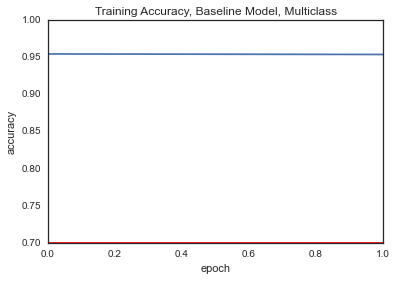

In [117]:
# The actual training of the CNN using the parameters and model previously specified.
# The validation set is a split of the stratified sampled training data.
experiment = 'Baseline Model, Multiclass'
accuracy, train_time = train_evaluate_CNN(x_train, y_train, x_test, y_test, model, 
                                          batch_size, epochs=100, 
                                          verbose=debug_flag, show_layers=1,
                                          validation_split=0.15, 
                                          weights_filename='baseline', 
                                          plot_title=experiment)
experiment_results = experiment_results.append({'Name' : experiment, 
                                                'Test Accuracy' : accuracy, 
                                                'Train Time': train_time}, ignore_index=True)

From the above, we see that this model with 200 epochs (which includes some slight tuning) yielded an impressive accuracy of 70% on the unseen test set, and 95% accuracy on the training set.  Next, we will add another convultional, dropout, and pooling layer and see the results.

In [19]:
# create an empty network model
model2 = Sequential()

# Input Layer
model2.add(Conv2D(16, kernel_size=input_kernel_size, activation=input_activation_function, input_shape=input_shape))
model2.add(MaxPooling2D(pool_size=pool_size))

# Hidden Layer(s)
model2.add(Conv2D(32, kernel_size=hidden_kernel_size, activation=hidden_activation_function))
model2.add(Dropout(0.25))
model2.add(MaxPooling2D(pool_size=pool_size))

model2.add(Conv2D(48, kernel_size=hidden_kernel_size, activation=hidden_activation_function))
model2.add(Dropout(0.25))
model2.add(MaxPooling2D(pool_size=pool_size))

# Classification layer
model2.add(Flatten())
model2.add(Dense(64, activation=hidden_activation_function))
model2.add(Dropout(0.5))
model2.add(Dense(classes, activation=final_activation_function))

# Compile the model.
model2.compile(loss=loss_method, optimizer=optimizer, metrics=[eval_metric])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (None, 134, 88, 16)       1216      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 44, 29, 16)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 42, 27, 32)        4640      
_________________________________________________________________
dropout_3 (Dropout)          (None, 42, 27, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 9, 32)         0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 12, 7, 48)         13872     
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 7, 48)         0         
__________

Train on 4246 samples, validate on 750 samples
Epoch 1/2
4246/4246 [==============================] - 50s - loss: 0.7512 - acc: 0.7581 - val_loss: 9.8704 - val_acc: 0.0040
Epoch 2/2
4246/4246 [==============================] - 47s - loss: 0.6751 - acc: 0.7817 - val_loss: 10.1353 - val_acc: 0.0027
Time to train model with  2  epochs is :  97.9920871258  seconds.
992/997 [============================>.] - ETA: 0sTest loss: 2.306823939
Test accuracy: 0.595787362086
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (None, 134, 88, 16)       1216      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 44, 29, 16)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 42, 27, 32)        4640      
_________________________________________________________________
dropo

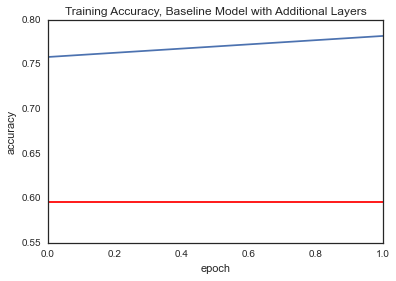

In [118]:
# The actual training of the CNN using the parameters and model previously specified.
experiment = 'Baseline Model with Additional Layers, Multiclass'
accuracy, train_time = train_evaluate_CNN(x_train, y_train, x_test, y_test, model2, 
                                          batch_size, epochs=100, 
                                          verbose=debug_flag, show_layers=True,
                                          validation_split=0.15, 
                                          weights_filename='baseline_addl_layer', 
                                          plot_title=experiment)
experiment_results = experiment_results.append({'Name' : experiment, 
                                                'Test Accuracy' : accuracy, 
                                                'Train Time': train_time}, ignore_index=True)

### Solution

Complete description of the deep network you trained from scratch, including parameter settings, performance, features learned, etc.

From the above results, we see that this model with 250 epochs and nother convultional, dropout, and pooling layer  yielded an accuracy of ~60% on the unseen test set, and 75% accuracy on the training set.  This is a reduction of 20% accuracy on the training set and a 10% reduction on the test set, from the previous, simpler model.  It is believed that the addition of the convolutional layer and pooling layer are simplifing the details of the image excessively and loosing detail.

### Tune an existing CNN (Multi-class)

The following code is used with modification from the sample InceptionV3 code from the Keras documentation, https://keras.io/applications/

In [67]:
# Create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer 
predictions = Dense(classes, activation=final_activation_function)(x)

# this is the model we will train
model_tune = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model_tune.compile(optimizer='rmsprop', loss=loss_method,  metrics=[eval_metric])

Train on 4246 samples, validate on 750 samples
Epoch 1/2
4246/4246 [==============================] - 252s - loss: 0.0361 - acc: 0.9967 - val_loss: 15.9980 - val_acc: 0.0040
Epoch 2/2
4246/4246 [==============================] - 236s - loss: 0.0391 - acc: 0.9958 - val_loss: 15.9960 - val_acc: 0.0040
Time to train model with  2  epochs is :  489.058491945  seconds.
997/997 [==============================] - 49s    
Test loss: 3.17053570312
Test accuracy: 0.704112337011
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_758 (Conv2D)              (None, None, None, 32 864                                          
______________________

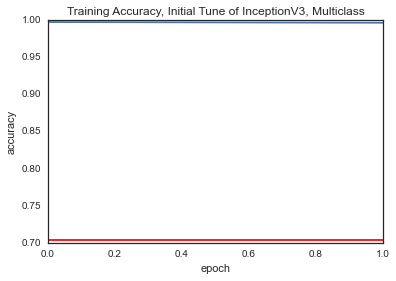

In [119]:
# train the model on the new data for a few epochs
# fine-tune the model
experiment = 'Initial Tune of InceptionV3, Multiclass'
accuracy, train_time = train_evaluate_CNN(x_train, y_train, x_test, y_test, model_tune, 
                                          batch_size, epochs=25, 
                                          verbose=debug_flag, show_layers=True,
                                          validation_split=0.15, 
                                          weights_filename='inceptionv3_initial', 
                                          plot_title=experiment)
experiment_results = experiment_results.append({'Name' : experiment, 
                                                'Test Accuracy' : accuracy, 
                                                'Train Time': train_time}, ignore_index=True)

In [120]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss=loss_method,  metrics=[eval_metric])

0 input_9
1 conv2d_758
2 batch_normalization_753
3 activation_753
4 conv2d_759
5 batch_normalization_754
6 activation_754
7 conv2d_760
8 batch_normalization_755
9 activation_755
10 max_pooling2d_38
11 conv2d_761
12 batch_normalization_756
13 activation_756
14 conv2d_762
15 batch_normalization_757
16 activation_757
17 max_pooling2d_39
18 conv2d_766
19 batch_normalization_761
20 activation_761
21 conv2d_764
22 conv2d_767
23 batch_normalization_759
24 batch_normalization_762
25 activation_759
26 activation_762
27 average_pooling2d_73
28 conv2d_763
29 conv2d_765
30 conv2d_768
31 conv2d_769
32 batch_normalization_758
33 batch_normalization_760
34 batch_normalization_763
35 batch_normalization_764
36 activation_758
37 activation_760
38 activation_763
39 activation_764
40 mixed0
41 conv2d_773
42 batch_normalization_768
43 activation_768
44 conv2d_771
45 conv2d_774
46 batch_normalization_766
47 batch_normalization_769
48 activation_766
49 activation_769
50 average_pooling2d_74
51 conv2d_770
52

Train on 4246 samples, validate on 750 samples
Epoch 1/2
4246/4246 [==============================] - 265s - loss: 0.1454 - acc: 0.9691 - val_loss: 16.0001 - val_acc: 0.0040
Epoch 2/2
4246/4246 [==============================] - 263s - loss: 0.0223 - acc: 0.9967 - val_loss: 16.0098 - val_acc: 0.0040
Time to train model with  2  epochs is :  529.283214808  seconds.
997/997 [==============================] - 51s    
Test loss: 3.18142711734
Test accuracy: 0.702106318957
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_758 (Conv2D)              (None, None, None, 32 864                                          
______________________

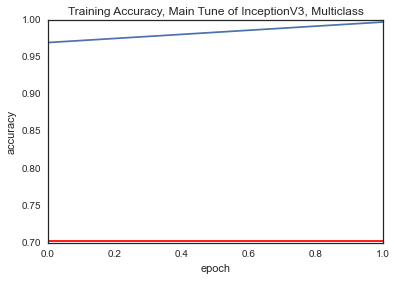

In [121]:
# Fine tune the new model, using the "fine" parameters of SGD previously defined.
experiment = 'Fine Tune of InceptionV3, Multiclass'
accuracy, train_time = train_evaluate_CNN(x_train, y_train, x_test, y_test, model_tune, 
                                          batch_size, epochs=50, 
                                          verbose=debug_flag, show_layers=False,
                                          validation_split=0.15, 
                                          weights_filename='inceptionv3_finetune', 
                                          plot_title=experiment)
experiment_results = experiment_results.append({'Name' : experiment, 
                                                'Test Accuracy' : accuracy, 
                                                'Train Time': train_time}, ignore_index=True)

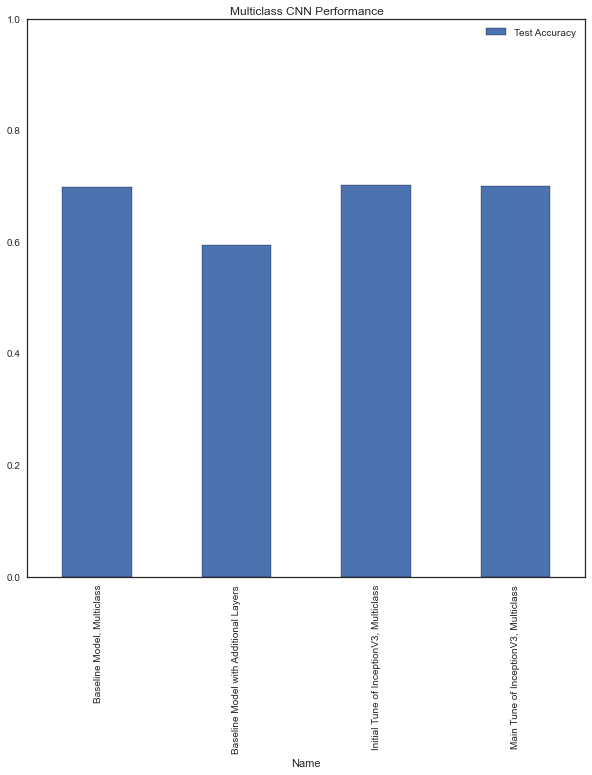

In [135]:
experiment_results.plot(x='Name', y='Test Accuracy', kind='bar', 
                        title='Multiclass CNN Performance', ylim=(0,1.0), figsize=(10,10));

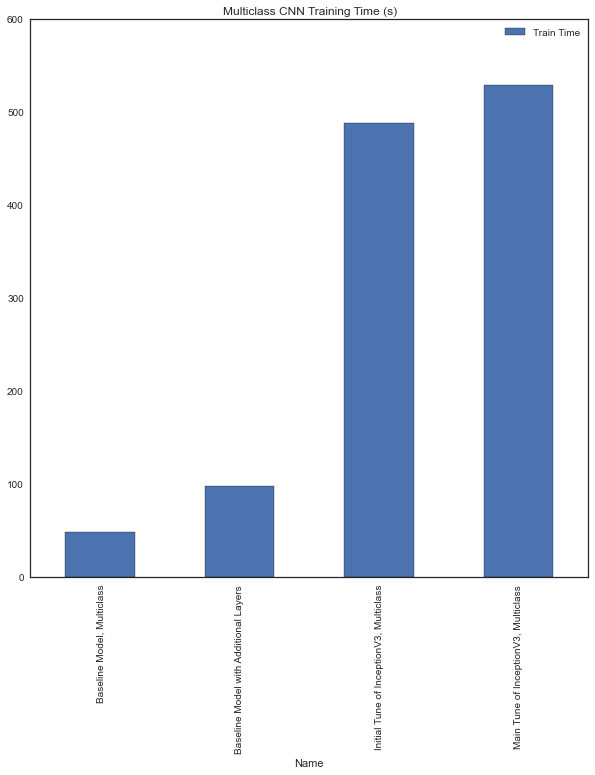

In [134]:
experiment_results.plot(x='Name', y='Train Time', kind='bar', 
                        title='Multiclass CNN Training Time (s)', figsize=(10,10));

### Solution

Complete description of the pre-trained network that you fine tuned, including parameter settings, performance, features learned, etc.

Discussion of the results, how much improvement you gained with fine tuning, etc.

Discussion of at least one additional exploratory idea you pursued


#### Anecdotal Learnings
I've run this with up to 250 epochs, but the result stabilizes around 50 epochs, thus for computational efficiency during reruns I will choose 50.

An additional learning is that breaking (not restarting the kernel) seems to keep the latest trained weights, and as such incremental reruns will continue to tune the weights.

### Create the Convolutional Neural Net architecture, from scratch (Multi-label)

In [154]:
def load_poster_data_multilabel(image_size, source_size = 'w92', verbose = False):
    # Loads the poster image data at the requested size, the assigned genre, and the movie id.
    #
    y_labels = pd.read_csv('y_labels_multilabel.csv')
        
    image_path = './posters/' + source_size + '/'
    posters = pd.DataFrame()
    for movie in y_labels.iterrows():
        row = movie[0]
        movie_id = movie[1]['movie_id']
        genre_ids = movie[1]['genre_id'].replace('[', '').replace(']','').split(',')
        try:
            image = misc.imread(image_path + str(movie_id) + '.jpg')
            image_resize = img_to_array(misc.imresize(image, image_size))
            if (image_resize.shape[2]==3):
                posters = posters.append({'movie_id' : movie_id, 
                                          'genre_id' : genre_ids,
                                          'poster' : image_resize}, ignore_index = True)
        except IOError:
            if (verbose == True):
                print('Unable to load poster for movie #', movie_id)
    print('Loaded ', posters.shape[0], ' posters.')
    return posters

In [227]:
temp = load_poster_data_multilabel((138,92), 'w92', False)

Loaded  6824  posters.


In [248]:
train_sample = temp.sample(5000, replace="False")
test_sample = temp.sample(1000, replace="False")

train_posters = train_sample["poster"]
test_posters = test_sample["poster"]

img_rows = x_train[0].shape[0]
img_cols = x_train[0].shape[1]

x_train = reshape_and_normalize(train_posters.as_matrix())
x_test = reshape_and_normalize(test_posters.as_matrix())

y_train = train_sample["genre_id"]
y_test = test_sample["genre_id"]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (5000, 138, 92, 3)
5000 train samples
1000 test samples


In [249]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)
classes = max(y_train.shape[1], y_test.shape[1])

In [250]:
loss_method='binary_crossentropy'
final_activation_function = 'sigmoid'

In [251]:
# create an empty network model
model_ml = Sequential()

# Input Layer
model_ml.add(Conv2D(16, kernel_size=input_kernel_size, activation=input_activation_function, input_shape=input_shape))
model_ml.add(MaxPooling2D(pool_size=pool_size))

# Hidden Layer(s)
model_ml.add(Conv2D(32, kernel_size=hidden_kernel_size, activation=hidden_activation_function))
model_ml.add(Dropout(0.25))
model_ml.add(MaxPooling2D(pool_size=pool_size))

# Classification layer
model_ml.add(Flatten())
model_ml.add(Dense(64, activation=hidden_activation_function))
model_ml.add(Dropout(0.5))
model_ml.add(Dense(classes, activation=final_activation_function))

# Compile the model.
model_ml.compile(loss=loss_method, optimizer=optimizer, metrics=[eval_metric])

Train on 4250 samples, validate on 750 samples
Epoch 1/10
4250/4250 [==============================] - 54s - loss: 0.5075 - acc: 0.7742 - val_loss: 0.3956 - val_acc: 0.8408
Epoch 2/10
4250/4250 [==============================] - 46s - loss: 0.4111 - acc: 0.8360 - val_loss: 0.3955 - val_acc: 0.8410
Epoch 3/10
4250/4250 [==============================] - 46s - loss: 0.4022 - acc: 0.8377 - val_loss: 0.3958 - val_acc: 0.8408
Epoch 4/10
4250/4250 [==============================] - 45s - loss: 0.3999 - acc: 0.8375 - val_loss: 0.3974 - val_acc: 0.8408
Epoch 5/10
4250/4250 [==============================] - 45s - loss: 0.3981 - acc: 0.8376 - val_loss: 0.3921 - val_acc: 0.8408
Epoch 6/10
4250/4250 [==============================] - 45s - loss: 0.3955 - acc: 0.8365 - val_loss: 0.3969 - val_acc: 0.8408
Epoch 7/10
4250/4250 [==============================] - 45s - loss: 0.3918 - acc: 0.8372 - val_loss: 0.3904 - val_acc: 0.8400
Epoch 8/10
4250/4250 [==============================] - 45s - loss: 0.3

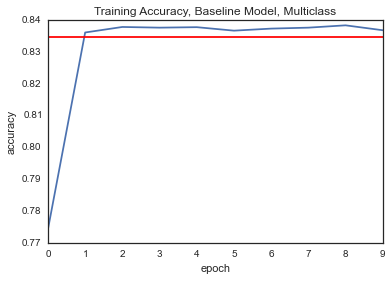

In [252]:
# The actual training of the CNN using the parameters and model previously specified.
experiment = 'Baseline Model, Multiclass'
accuracy, train_time = train_evaluate_CNN(x_train, y_train, x_test, y_test, model_ml, 
                                          batch_size, epochs=10, 
                                          verbose=debug_flag, show_layers=1,
                                          validation_split=0.15, 
                                          weights_filename='baseline', 
                                          plot_title=experiment)
experiment_results = experiment_results.append({'Name' : experiment, 
                                                'Test Accuracy' : accuracy, 
                                                'Train Time': train_time}, ignore_index=True)

In [253]:
test_genre_probabilities = np.array(model_ml.predict_proba(x_test))

1000/1000 [==============================] - 7s     


In [262]:
y_test[:5,]

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]])

In [263]:
test_genre_probabilities[:5,]

array([[ 0.1431644 ,  0.05037608,  0.18038495,  0.19424695,  0.38949347,
         0.0662197 ,  0.48246527,  0.26180673,  0.16029488,  0.19431081,
         0.04054456],
       [ 0.2051394 ,  0.08941647,  0.19161998,  0.26105216,  0.26306432,
         0.09838844,  0.48168555,  0.19462857,  0.24593787,  0.12883382,
         0.05947982],
       [ 0.17706594,  0.06913378,  0.1846213 ,  0.24157576,  0.31752616,
         0.08578575,  0.46006393,  0.22777764,  0.20644818,  0.14529388,
         0.04896683],
       [ 0.24427934,  0.11969148,  0.18877856,  0.29397687,  0.21594547,
         0.13892125,  0.4804576 ,  0.16712892,  0.31630695,  0.097451  ,
         0.09229746],
       [ 0.13322692,  0.0408937 ,  0.17213979,  0.18641512,  0.39111164,
         0.05740606,  0.48088109,  0.25047982,  0.14134116,  0.1844821 ,
         0.03367892]], dtype=float32)

### References Used
https://keras.io/callbacks/

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

https://keras.io/getting-started/faq/#how-can-i-use-keras-with-datasets-that-dont-fit-in-memory

https://elitedatascience.com/keras-tutorial-deep-learning-in-python#step-4

http://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/